In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [2]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        list_of_predict = {}
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [3]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_00/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.249% 	8.91282% 	0.04888		0.04563		0.0		1.0	
(1024,256) 	95.4% 		0.49086% 	6.40602% 	0.82382		0.83287		0.0		0.98881	
(1024,1024) 	3.04% 		1.88876% 	2.25471% 	0.02452		0.00286		0.0		0.56883	


In [4]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 1.00000 1.00000 0.00000 	(213910, 0.9037879560274013) 0.91948 0.90379 0.01569 	(688427, 0.938751472320377) 0.00671 0.93875 0.93204 	
(32635, 1.0) 1.00000 1.00000 0.00000 	(212974, 0.8941978001127759) 0.89727 0.89420 0.00308 	(4240, 0.9623085983510011) 0.23896 0.96231 0.72334 	
(2436, 1.0) 0.98725 1.00000 0.01275 	(44828, 0.8401417658060423) 0.86901 0.84014 0.02886 	(694929, 0.9799764428739693) 0.00619 0.97998 0.97378 	
(55808, 1.0) 0.84739 1.00000 0.15261 	(232148, 0.8783613613364569) 0.88942 0.87836 0.01106 	(600540, 0.5747938751472321) 0.01367 0.57479 0.56112 	
(44159, 1.0) 0.99912 1.00000 0.00088 	(106790, 0.8420843224691953) 0.85826 0.84208 0.01618 	(226406, 0.8680800942285042) 0.07654 0.86808 0.79154 	
(25344, 1.0) 1.00000 1.00000 0.00000 	(155900, 0.8219974944514251) 0.86602 0.82200 0.04402 	(122896, 0.99528857

(3712, 1.0) 0.99855 1.00000 0.00145 	(202386, 0.8547444588701087) 0.85323 0.85474 0.00152 	(551702, 0.9375736160188458) 0.00195 0.93757 0.93562 	
(56196, 1.0) 0.99945 1.00000 0.00055 	(211174, 0.8623937046282677) 0.89019 0.86239 0.02779 	(536059, 0.9128386336866903) 0.01004 0.91284 0.90280 	
(24572, 1.0) 0.99996 1.00000 0.00004 	(204929, 0.9002994302722791) 0.87039 0.90030 0.02991 	(15661, 0.9846878680800943) 0.14145 0.98469 0.84324 	
(85763, 1.0) 1.00000 1.00000 0.00000 	(208872, 0.8890624352956111) 0.88543 0.88906 0.00363 	(296015, 0.9305064782096585) 0.27554 0.93051 0.65497 	
(96449, 1.0) 0.99867 1.00000 0.00133 	(171157, 0.9045602107586476) 0.89143 0.90456 0.01313 	(10273, 0.9469964664310954) 0.28772 0.94700 0.65928 	
(63755, 1.0) 0.99982 1.00000 0.00018 	(182271, 0.8488394748464482) 0.86217 0.84884 0.01333 	(317777, 0.001177856301531247) 0.02420 0.00118 0.02302 	
(5627, 1.0) 1.00000 1.00000 0.00000 	(152043, 0.835477761540477) 0.84949 0.83548 0.01402 	(208524, 0.9210836277974088) 

(30093, 1.0) 1.00000 1.00000 0.00000 	(138646, 0.9098066982562631) 0.88118 0.90981 0.02863 	(189848, 0.8386336866902238) 0.04355 0.83863 0.79509 	
(96515, 1.0) 0.55675 1.00000 0.44325 	(116458, 0.8343063704857346) 0.88712 0.83431 0.05281 	(52414, 0.977620730270907) 0.15951 0.97762 0.81811 	
(13694, 1.0) 1.00000 1.00000 0.00000 	(31638, 0.8294063933722998) 0.85181 0.82941 0.02241 	(157072, 0.8032979976442876) 0.03915 0.80330 0.76414 	
(25232, 1.0) 0.97854 1.00000 0.02146 	(91863, 0.8671667781497853) 0.89578 0.86717 0.02861 	(131092, 0.8386336866902238) 0.22826 0.83863 0.61037 	
(54815, 1.0) 0.99950 1.00000 0.00050 	(221635, 0.8710193142381297) 0.89498 0.87102 0.02396 	(373002, 0.96113074204947) 0.03454 0.96113 0.92659 	
(31259, 1.0) 1.00000 1.00000 0.00000 	(210727, 0.8573664020360111) 0.89122 0.85737 0.03386 	(12957, 0.8621908127208481) 0.06357 0.86219 0.79862 	
(46331, 1.0) 0.99999 1.00000 0.00001 	(168194, 0.8780051560399823) 0.88421 0.87801 0.00621 	(702686, 0.8704358068315666) 0.01

(30380, 1.0) 1.00000 1.00000 0.00000 	(148287, 0.9223860427843692) 0.92369 0.92239 0.00131 	(146602, 0.9305064782096585) 0.15774 0.93051 0.77277 	
(34962, 1.0) 0.99284 1.00000 0.00716 	(159120, 0.8879360563357201) 0.88826 0.88794 0.00032 	(121940, 0.7997644287396938) 0.15951 0.79976 0.64026 	
(13180, 1.0) 0.99799 1.00000 0.00201 	(198907, 0.8310276470899663) 0.88225 0.83103 0.05122 	(657009, 0.9988221436984688) 0.00803 0.99882 0.99079 	
(1550, 1.0) 0.57471 1.00000 0.42529 	(224142, 0.889940877844756) 0.89354 0.88994 0.00360 	(212570, 0.9988221436984688) 0.00835 0.99882 0.99047 	
(7815, 1.0) 1.00000 1.00000 0.00000 	(174985, 0.8706255523835676) 0.88096 0.87063 0.01033 	(362521, 0.8833922261484101) 0.06715 0.88339 0.81624 	
(3207, 1.0) 0.22061 1.00000 0.77939 	(205549, 0.8558976987056945) 0.88369 0.85590 0.02780 	(578851, 0.4546525323910483) 0.01349 0.45465 0.44116 	
(103682, 1.0) 1.00000 1.00000 0.00000 	(97283, 0.8187489655771295) 0.88475 0.81875 0.06600 	(2555, 0.3439340400471143) 0.1

(78082, 1.0) 1.00000 1.00000 0.00000 	(168996, 0.9139235269983209) 0.87154 0.91392 0.04238 	(185377, 0.38162544169611307) 0.15951 0.38163 0.22212 	
(59008, 1.0) 0.99013 1.00000 0.00987 	(145688, 0.8840907926988386) 0.90633 0.88409 0.02224 	(30880, 0.9988221436984688) 0.16358 0.99882 0.83524 	
(22315, 1.0) 0.99996 1.00000 0.00004 	(75870, 0.893131239258136) 0.87174 0.89313 0.02139 	(828942, 0.3074204946996466) 0.00290 0.30742 0.30452 	
(111104, 1.0) 1.00000 1.00000 0.00000 	(69828, 0.8517223587035576) 0.85795 0.85172 0.00623 	(148527, 0.5159010600706715) 0.15951 0.51590 0.35639 	
(10757, 1.0) 1.00000 1.00000 0.00000 	(170585, 0.8485697421085276) 0.87398 0.84857 0.02541 	(9486, 0.9104829210836279) 0.10357 0.91048 0.80691 	
(60419, 1.0) 0.99077 1.00000 0.00923 	(252754, 0.8910089570519085) 0.91530 0.89101 0.02429 	(2410, 0.5017667844522969) 0.08321 0.50177 0.41855 	
(108160, 1.0) 1.00000 1.00000 0.00000 	(484, 0.7804441747798809) 0.42337 0.78044 0.35708 	(119845, 0.7078916372202592) 0.159

(87555, 1.0) 1.00000 1.00000 0.00000 	(172056, 0.8863237881002124) 0.85718 0.88632 0.02914 	(84089, 0.9988221436984688) 0.15951 0.99882 0.83931 	
(43020, 1.0) 0.61461 1.00000 0.38539 	(10645, 0.7872318198557479) 0.55200 0.78723 0.23523 	(605321, 0.92226148409894) 0.04226 0.92226 0.88000 	
(39045, 1.0) 0.99496 1.00000 0.00504 	(23776, 0.8078787059174175) 0.84451 0.80788 0.03663 	(12576, 0.9988221436984688) 0.14975 0.99882 0.84907 	
(8601, 1.0) 0.93968 1.00000 0.06032 	(227769, 0.8706296421060487) 0.88618 0.87063 0.01555 	(372904, 0.9658421672555949) 0.04950 0.96584 0.91634 	
(98307, 1.0) 1.00000 1.00000 0.00000 	(98936, 0.8264761295751925) 0.87186 0.82648 0.04539 	(303380, 0.9340400471142521) 0.03709 0.93404 0.89695 	
(30989, 1.0) 1.00000 1.00000 0.00000 	(30949, 0.8629280548822288) 0.84537 0.86293 0.01756 	(304265, 0.5111896348645465) 0.05959 0.51119 0.45160 	
(129921, 1.0) 1.00000 1.00000 0.00000 	(42822, 0.7588843823223201) 0.89903 0.75888 0.14014 	(84196, 0.92226148409894) 0.10071 0

(127745, 1.0) 1.00000 1.00000 0.00000 	(179993, 0.8515489276398169) 0.86594 0.85155 0.01440 	(198150, 0.4994110718492344) 0.02510 0.49941 0.47431 	
(25415, 1.0) 0.99580 1.00000 0.00420 	(175409, 0.9156561570916643) 0.86970 0.91566 0.04596 	(199688, 0.9988221436984688) 0.23761 0.99882 0.76121 	
(3204, 1.0) 0.52593 1.00000 0.47407 	(66930, 0.8611952742911493) 0.90290 0.86120 0.04171 	(82973, 0.9988221436984688) 0.17289 0.99882 0.82593 	
(258, 1.0) 0.73855 1.00000 0.26145 	(32418, 0.7914176499394617) 0.84540 0.79142 0.05398 	(374080, 0.9269729093050648) 0.02312 0.92697 0.90385 	
(87300, 1.0) 1.00000 1.00000 0.00000 	(231712, 0.8740718142169187) 0.87105 0.87407 0.00302 	(181452, 0.6383981154299176) 0.06009 0.63840 0.57830 	
(1694, 1.0) 0.14949 1.00000 0.85051 	(28015, 0.8047441309420261) 0.83758 0.80474 0.03284 	(609111, 0.2096584216725559) 0.00058 0.20966 0.20908 	
(7261, 1.0) 1.00000 1.00000 0.00000 	(194768, 0.8829893599177296) 0.90549 0.88299 0.02250 	(546928, 1.0) 0.04898 1.00000 0.95

(19206, 1.0) 0.99914 1.00000 0.00086 	(30238, 0.8125795508208419) 0.87087 0.81258 0.05829 	(83067, 0.9988221436984688) 0.15951 0.99882 0.83931 	
(24449, 1.0) 0.84987 1.00000 0.15013 	(65989, 0.8085392306592272) 0.85622 0.80854 0.04768 	(12653, 0.9988221436984688) 0.09421 0.99882 0.90461 	
(29952, 1.0) 1.00000 1.00000 0.00000 	(114239, 0.9571151205014997) 0.98451 0.95712 0.02739 	(298101, 0.7444051825677268) 0.05141 0.74441 0.69300 	
(56772, 1.0) 0.98766 1.00000 0.01234 	(186877, 0.8227595891327615) 0.85706 0.82276 0.03430 	(2086, 0.4711425206124853) 0.22344 0.47114 0.24770 	
(87424, 1.0) 1.00000 1.00000 0.00000 	(116177, 0.8549689190548719) 0.90842 0.85497 0.05345 	(55421, 0.7820965842167256) 0.15951 0.78210 0.62259 	
(21373, 1.0) 0.99992 1.00000 0.00008 	(127274, 0.848868760261584) 0.88039 0.84887 0.03152 	(2129, 0.7502944640753829) 0.22344 0.75029 0.52686 	
(39690, 1.0) 0.88255 1.00000 0.11745 	(20129, 0.8576348850484591) 0.80980 0.85763 0.04783 	(468994, 0.955241460541814) 0.11822 0

(50174, 1.0) 1.00000 1.00000 0.00000 	(76967, 0.83047846770885) 0.88026 0.83048 0.04978 	(7234, 0.9151943462897527) 0.29349 0.91519 0.62170 	
(2814, 1.0) 1.00000 1.00000 0.00000 	(252776, 0.8892230151839804) 0.90957 0.88922 0.02034 	(52327, 0.5488810365135454) 0.15951 0.54888 0.38937 	
(11277, 1.0) 0.96813 1.00000 0.03187 	(77818, 0.9227676313285499) 0.87166 0.92277 0.05111 	(152657, 0.9316843345111897) 0.10709 0.93168 0.82459 	
(60163, 1.0) 0.99987 1.00000 0.00013 	(258438, 0.7902965223513218) 0.83135 0.79030 0.04105 	(202868, 0.8881036513545347) 0.10307 0.88810 0.78503 	
(55557, 1.0) 0.99307 1.00000 0.00693 	(182357, 0.8287375376192538) 0.87009 0.82874 0.04135 	(167143, 0.9199057714958776) 0.08299 0.91991 0.83691 	
(2854, 1.0) 0.54711 1.00000 0.45289 	(28508, 0.7515108433756852) 0.80474 0.75151 0.05323 	(151792, 0.5924617196702003) 0.07396 0.59246 0.51851 	
(52860, 1.0) 1.00000 1.00000 0.00000 	(164944, 0.8762694408260925) 0.87368 0.87627 0.00259 	(184573, 0.9116607773851589) 0.06722

(82432, 1.0) 1.00000 1.00000 0.00000 	(25871, 0.8518134382070249) 0.82345 0.85181 0.02836 	(377985, 0.9281507656065962) 0.02441 0.92815 0.90374 	
(36735, 1.0) 0.98823 1.00000 0.01177 	(71630, 0.969761807998892) 0.89655 0.96976 0.07321 	(351424, 0.9988221436984688) 0.06020 0.99882 0.93862 	
(36351, 1.0) 0.99964 1.00000 0.00036 	(85077, 0.8957841738823206) 0.89691 0.89578 0.00113 	(639203, 0.9140164899882215) 0.01083 0.91402 0.90318 	
(2193, 1.0) 0.62490 1.00000 0.37510 	(165182, 0.9260564185888208) 0.87607 0.92606 0.04999 	(390524, 0.7302709069493521) 0.05006 0.73027 0.68021 	
(6663, 1.0) 1.00000 1.00000 0.00000 	(222390, 0.8651999222012362) 0.90224 0.86520 0.03704 	(153163, 0.9328621908127209) 0.02133 0.93286 0.91153 	
(42240, 1.0) 1.00000 1.00000 0.00000 	(30116, 0.8437491417362486) 0.86879 0.84375 0.02504 	(158958, 0.8386336866902238) 0.05937 0.83863 0.77926 	
(91034, 1.0) 1.00000 1.00000 0.00000 	(228742, 0.873035767853537) 0.88463 0.87304 0.01160 	(239994, 0.1107184923439341) 0.024

(15506, 1.0) 1.00000 1.00000 0.00000 	(151641, 0.8253741727779265) 0.85284 0.82537 0.02746 	(536622, 0.9599528857479388) 0.02686 0.95995 0.93310 	
(13181, 1.0) 0.99866 1.00000 0.00134 	(218687, 0.9106961520087443) 0.91762 0.91070 0.00692 	(396334, 0.9528857479387515) 0.16292 0.95289 0.78997 	
(6655, 1.0) 0.99999 1.00000 0.00001 	(14691, 0.8487331979469075) 0.77160 0.84873 0.07713 	(213272, 0.92226148409894) 0.05112 0.92226 0.87115 	
(8461, 1.0) 0.99873 1.00000 0.00127 	(46085, 0.8101512085909478) 0.85459 0.81015 0.04444 	(398977, 0.9199057714958776) 0.01047 0.91991 0.90944 	
(23297, 1.0) 0.79464 1.00000 0.20536 	(246423, 0.8630512310170013) 0.88075 0.86305 0.01769 	(559461, 0.30388692579505305) 0.03154 0.30389 0.27234 	
(16509, 1.0) 1.00000 1.00000 0.00000 	(121595, 0.9135095814918005) 0.86413 0.91351 0.04938 	(101579, 0.9269729093050648) 0.07427 0.92697 0.85270 	
(24960, 1.0) 0.99804 1.00000 0.00196 	(69825, 0.8932681074973093) 0.88147 0.89327 0.01180 	(448556, 0.8869257950530036) 0.0

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


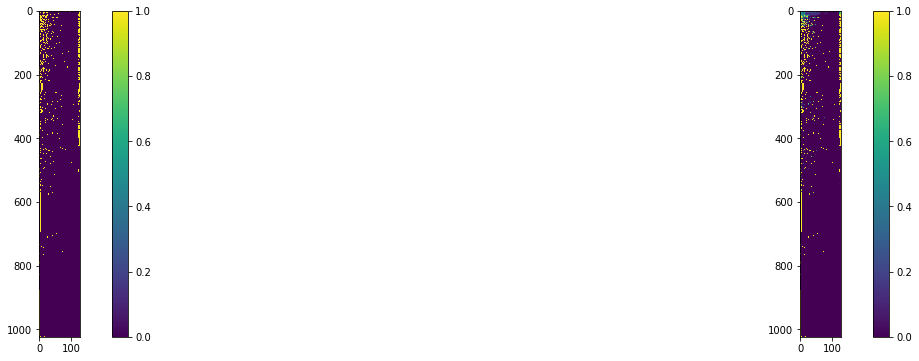

1.124458e-24
0.98880833


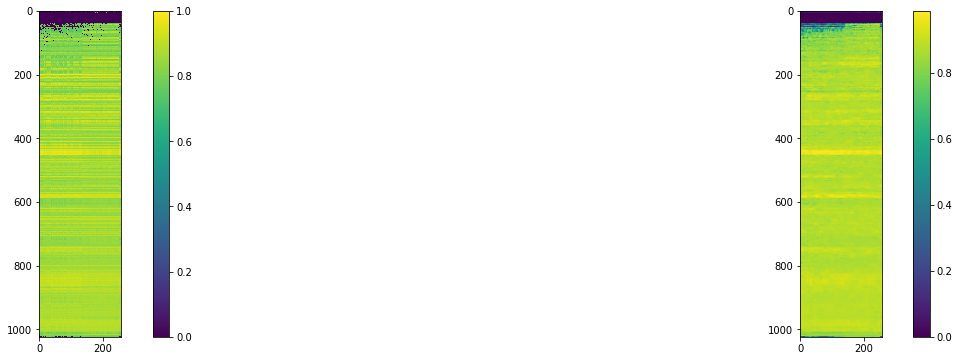

8.5233016e-14
0.56882685


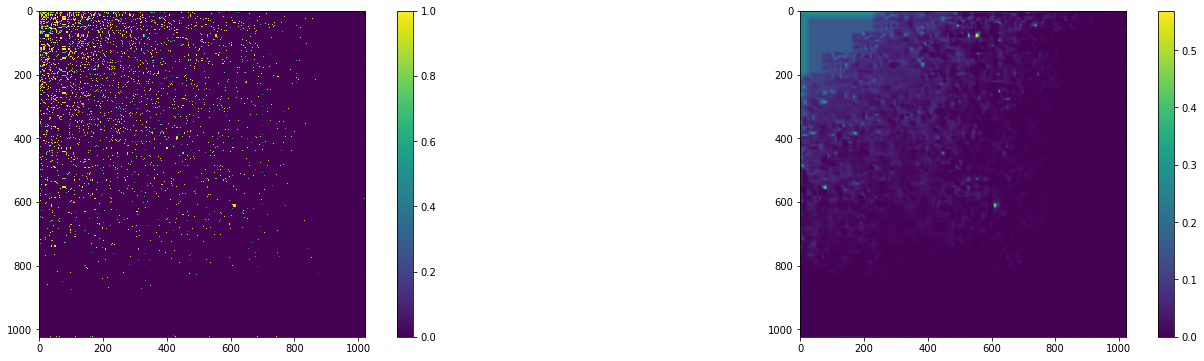

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_00/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
# color_pack2 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

#     ax = axes[2]
#     im = ax.imshow(predict - org_data, vmin=-1, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


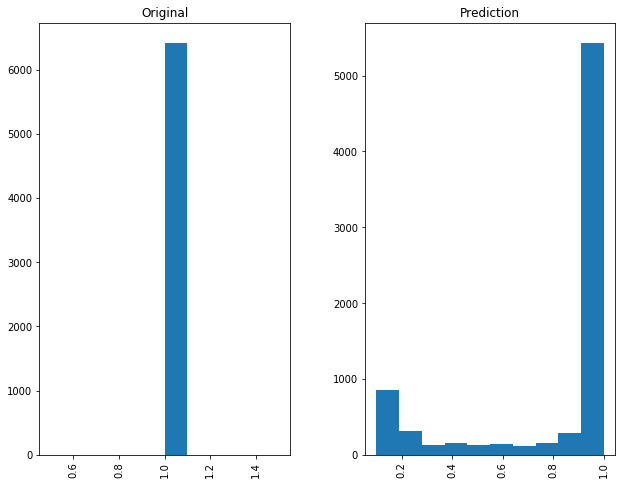

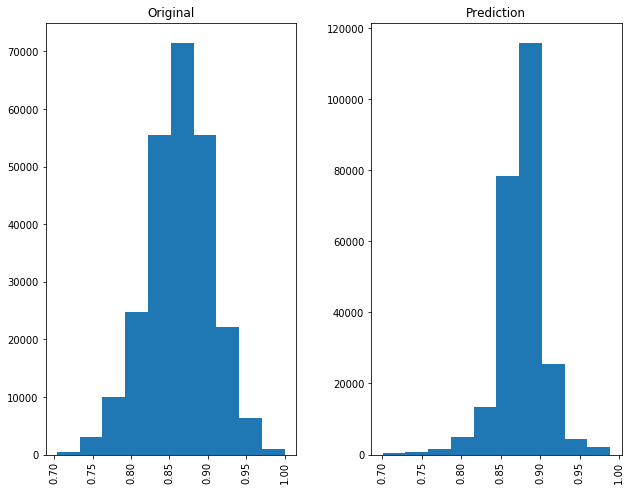

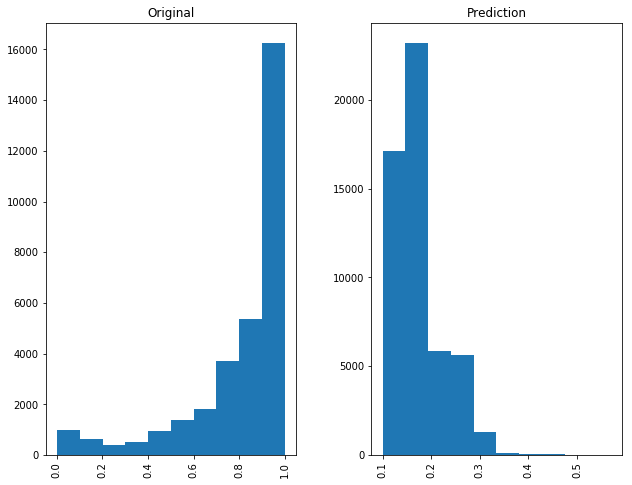

In [6]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'histogram_distribution_' + str(i))
    

/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


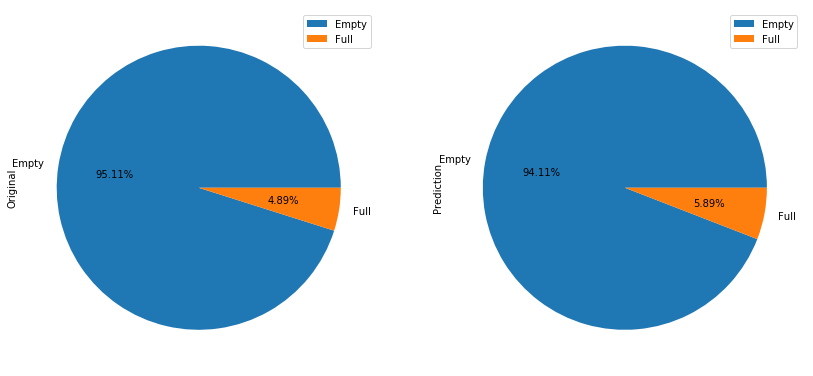

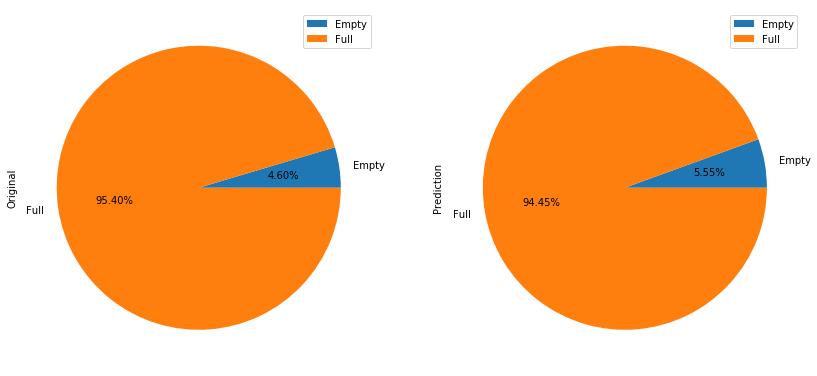

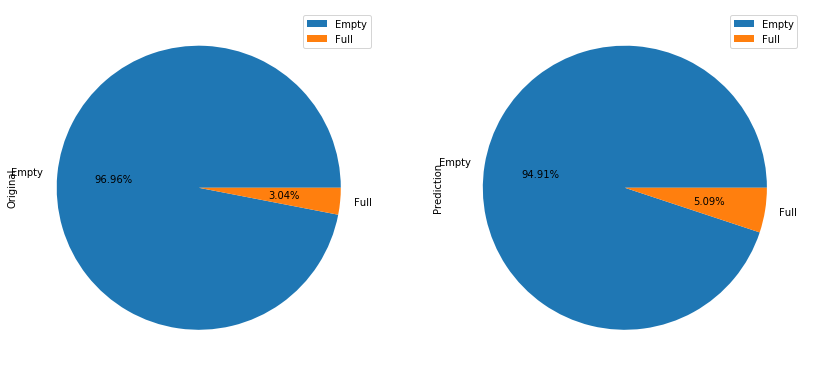

In [7]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    length = len(org_data)
    d = {}
    d['Original'] = []
    d['Original'].append(len(org_data[org_data == 0]) / length)
    d['Original'].append(len(org_data[org_data > 0]) / length)

    if i == 1:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.7]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.7]) / length)
    else:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.1]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.1]) / length)

    fig, ax = plt.subplots(figsize=(14,8))
    df = pd.DataFrame(d, index=['Empty', 'Full'])
    df.plot.pie(subplots=True, figsize=(14, 8), autopct='%.2f%%', ax=ax)
    fig.savefig(path + 'pie_density_' + str(i))

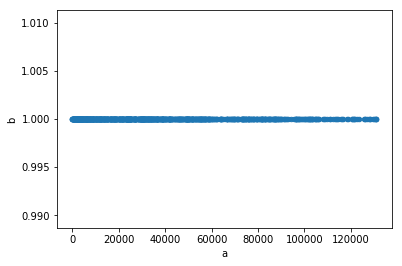

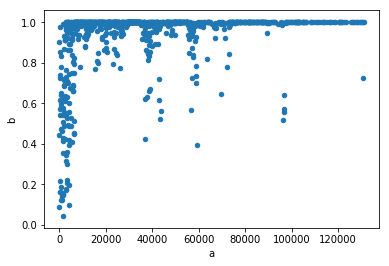

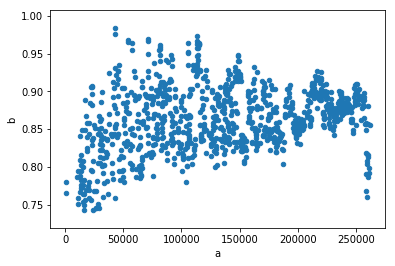

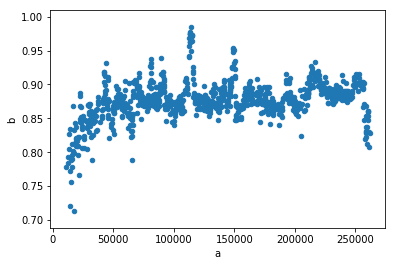

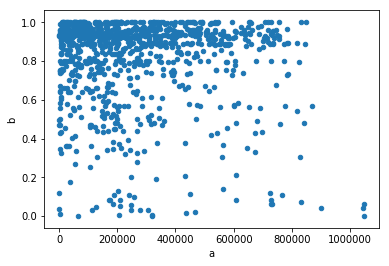

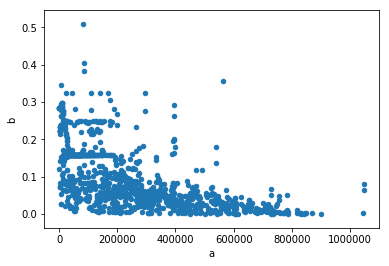

In [8]:
for i in range(len(model.org_data)):
    # df.plot.scatter(x='a', y='b');
    # print(np.random.rand(50, 4))
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    # print(data)
    new_org_data = []
    new_predict_data = []
    for j in range(len(org_data)):
        if i == 1:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            if predict_data[j][1] > 0.7:
                new_predict_data.append([predict_data[j][0], predict_data[j][1]])
        else:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            new_predict_data.append([predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(new_org_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    df = pd.DataFrame(new_predict_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    new_predict_data

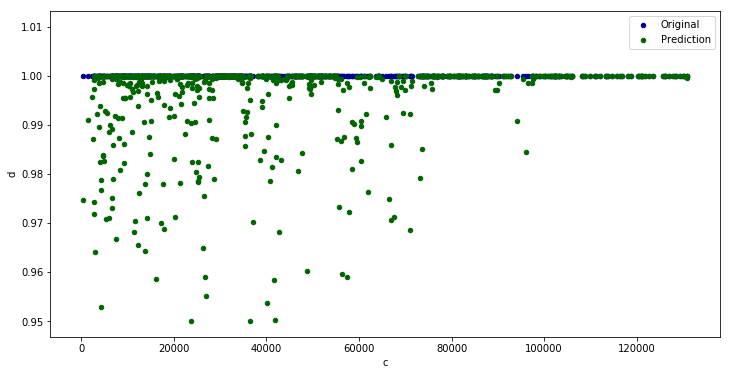

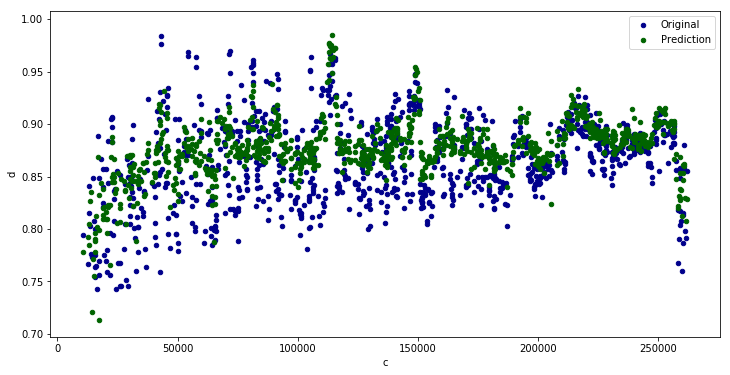

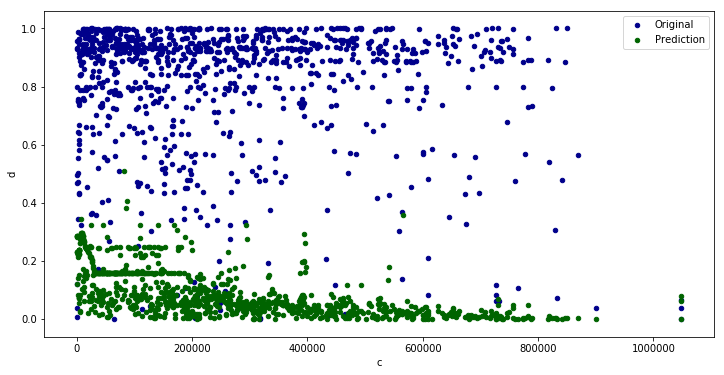

In [9]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original');
    df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));

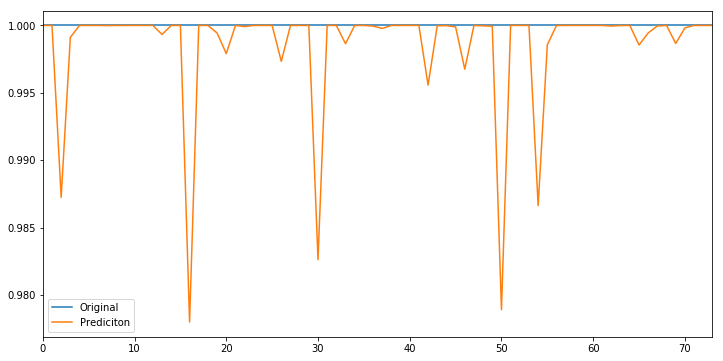

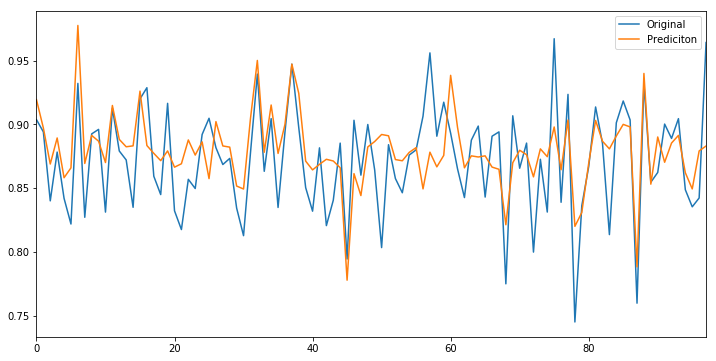

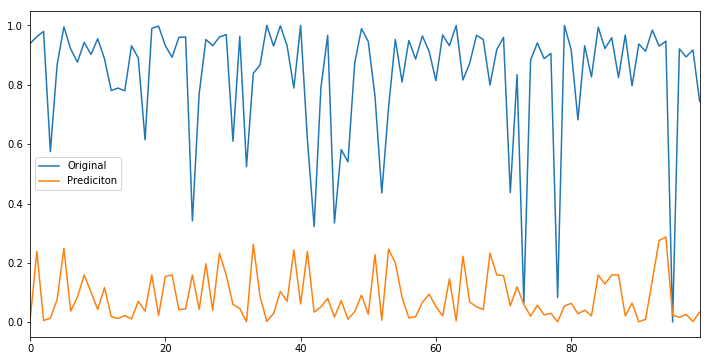

In [10]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data[:100])):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][1], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][1], predict_data[j][1]])
        else:
            data.append([org_data[j][1], predict_data[j][1]])

    fig, ax = plt.subplots(figsize=(12,6))
    df = pd.DataFrame(data, columns=['Original', 'Prediciton'])
    df.plot(subplots=False, figsize=(12,6), ax=ax)
    fig.savefig(path + 'graph_org_vs_prediction_' + str(i))